# LOAD EWAS Aging Data Brain and Analyze with Linear and XGboost models
DC

#### This notebook contains code to:
* load the EWAS aging text data file (age_methylation_v1.txt)
* rewrite it to a new csv file with just the samples from the  tissue the user specifies.
* read back into a dataframe in chunks the written file and combined the chunks into a new dataframe.
* transpose the dataframe and so cpgs are the columns
* add back columns for age and tissue
* drop all cpgs columns with more than 75% NAs
* fill remaining NAs with the mean for each column
* write pickled dataframe to a file.
* this df has dimensions (1437, 390440)
* select on samples with age over 20.
* this df has dimensions (1290, 390440)
* split data, working heldout 
* Run XGboost 50 time on working data (took 4hrs)
* Select top100 cpgs 
* fit models using just the top 100 cpgs, linear rg, XGboost, ridge_lg, lasso_lg
* run linear regression model on the saved data

#### Conclusions

* Running XGboost 50 times took 4hrs
* Models not as good as for whole blood

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [2]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

In [3]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')
os.getcwd()

'/Users/dcox/EWAS age premade'

### Function for loading data file and writing subset file by tissue, uses csv package for speed, not pandas

In [4]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [ ]:
%%time
# # Writing data to a file with the above function selecting out a certain tissue
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', './age_methylation_v1/brain_age_methylation_v1.txt', 'brain', num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000


### Read back in data in chunks and combine to new dataframe

In [ ]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv('./age_methylation_v1/brain_age_methylation_v1.txt', header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

In [ ]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

### Transpose dataframe so cpgs are columns, and add columns for age and tissue saved from the write operation

In [ ]:
%%time
# transposing dataframe
df_t = df.transpose()

In [ ]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [ ]:
df_t.shape

### Dealing with NAs

In [ ]:
# %%time
# #looking at a histogram of the percent NAs for the columns
# num_nans_hist = 100 * df_t.isna().sum(axis=0)/df_t.shape[0]
# num_nans_hist.hist(bins=100)
# plt.xlabel('% NA')
# plt.ylabel('count')
# plt.ylim(0,50000)

In [ ]:
#### Drop all columns with any NA

In [ ]:
%%time
# Drop all columns with an NA
# df_processed = df_t.dropna(axis=1)

In [ ]:
%%time
# df_processed.to_csv('df_EWAS_aging_brain_Na_droped')

#### Or drop all columns with  NAs > 25% of values , then imput with mean of column

In [ ]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [ ]:
df_processed_imp.shape

In [ ]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

In [ ]:
# %%time
# df_processed_imp.to_csv('df_EWAS_age_brain_Imputated_with_mean')

### Selecting out samples with ages over 20 years old

In [ ]:
# Selecting out samples with age > 20
# df_processed_over20 = df_processed[df_processed.age >=20]
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

### Histogram of ages in data

In [ ]:
# Histogram of ages in data
plt.figure(figsize = (6,4))
df_processed_imp_over20.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')
plt.show()

### Dividing data into working and saved parts

In [ ]:
df_processed_imp_over20.shape

In [ ]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

In [ ]:
# Histogram of ages in saved data
df_p_saved.age.hist(bins=20)
plt.show()

In [ ]:
# Histogram of ages in working data
df_p_working.age.hist(bins=20)
plt.show()

In [ ]:
df_p_working

In [46]:
# %%time
# # Runnin XGboost on working dataset 50 times with 50 different train/test splits
# df_imp, rms_train, rms_test, r2_train, r2_test = repeat_XGBoost(df_p_working, 50, test_size=0.20)

In [47]:
#df_imp

In [49]:
# write 50 trails results to a file, so don't have to rerun the 50 XGboost trials with the whole dataset again
# df_imp.to_csv('df_importance_EWAS_age_brain_50_trials.csv')
df_imp = pd.read_csv('./brain/df_importance_EWAS_age_brain_50_trials.csv', index_col=0)

In [50]:
# Finding cpgs with on average the highest importance scores, see mean columnn in df below
df_imp_sorted = importances_sorted_by_mean(df_imp)

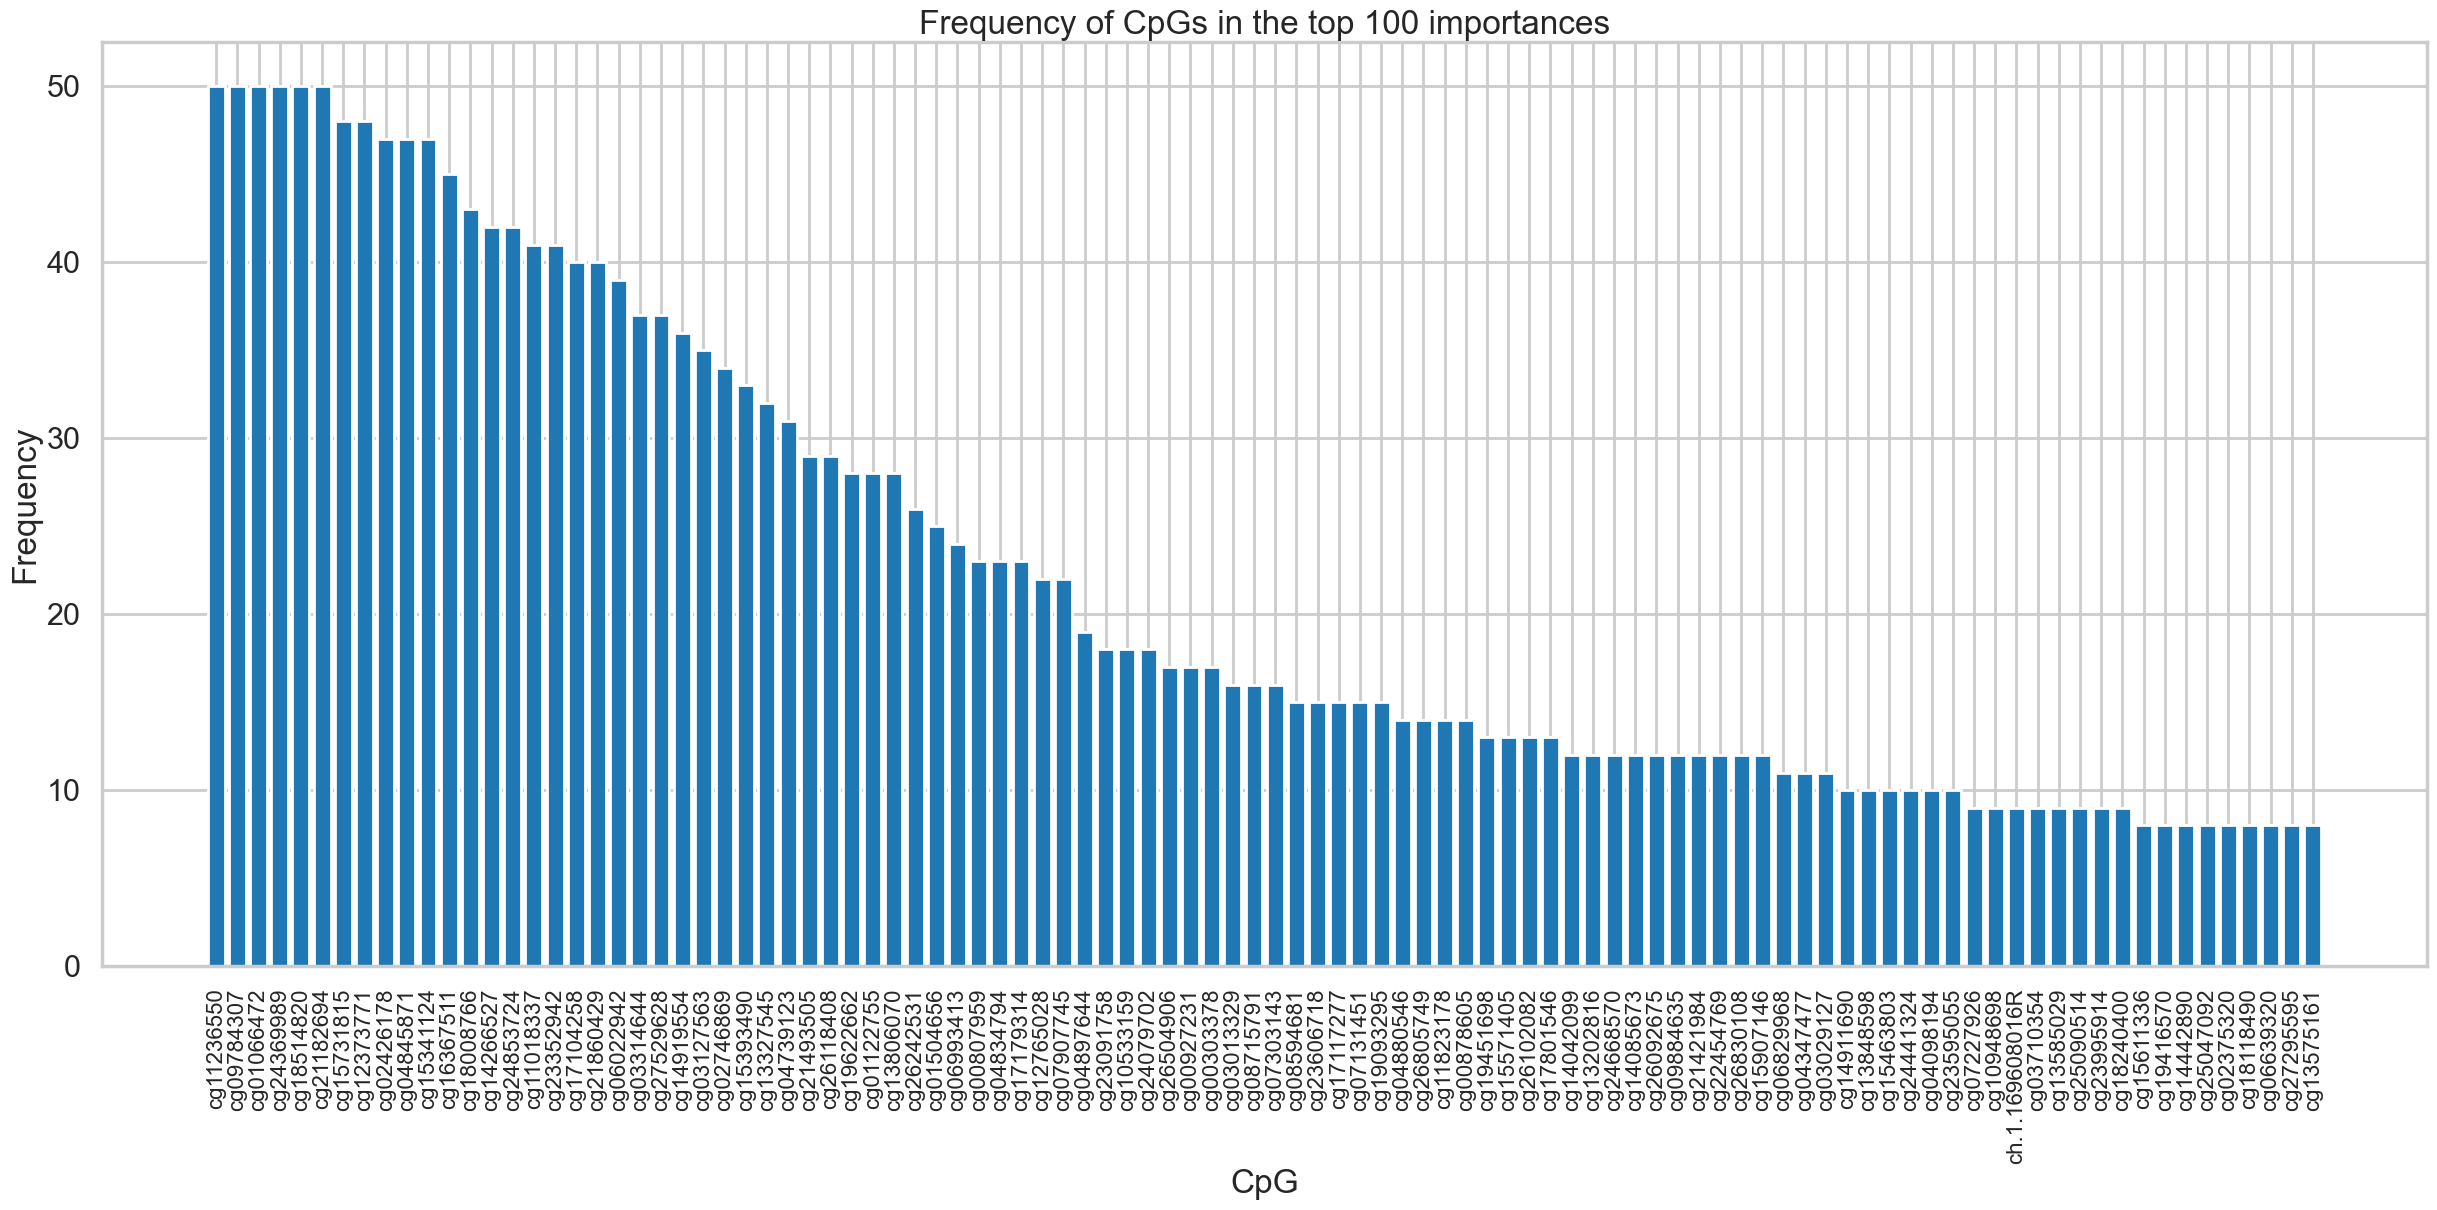

In [51]:
# This function makes a histogram of the frequency of cgs in the top 100 in the 50 trials above
inds, vs, h = histogram_of_top_CpGs_by_importance(df_imp, 100)

In [52]:
cpgs_XGboost_brain_ranked = h.index.values

In [53]:
# Savings Rankings, took 4hrs to get
# import pickle
# with open('cpgs_XGboost_brain_ranked', 'wb') as fp:
#     pickle.dump(cpgs_XGboost_brain_ranked, fp)

In [54]:
Top100_cpgs_XGboost_brain = h.index[:100].values

In [55]:
from sklearn.model_selection import train_test_split
X = df_p_working[Top100_cpgs_XGboost_brain]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

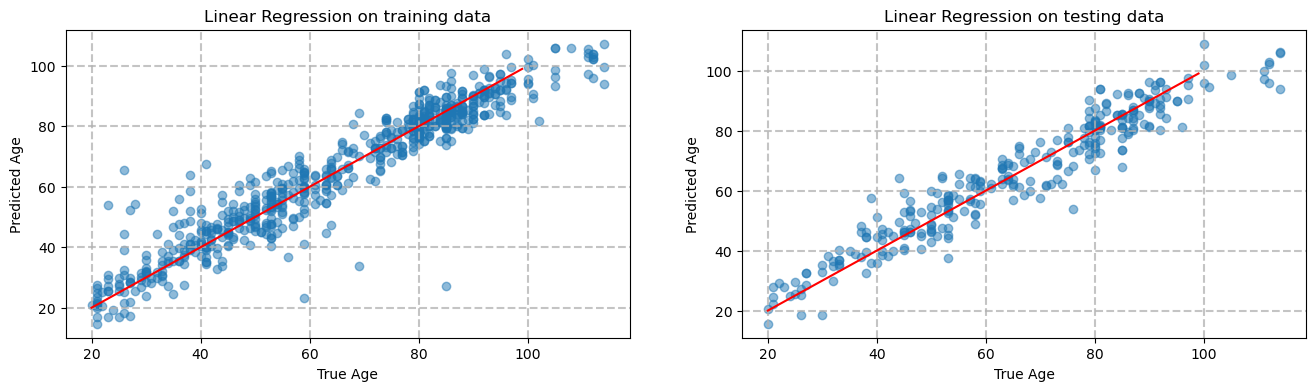

The rms on the training data is 6.953 years
The rms on the testing data is 6.284 years
The r^2 on the training data is 0.906
The r^2 on the testing data is 0.919
The MAe on the training data is 4.703 years
The MAE on the testing data is 4.906


In [56]:
plt.rcdefaults()
mod_100, rms_train, rms_test, r2_train, r2_test = linear_regress(X_train, y_train, X_test, y_test, plot=True)

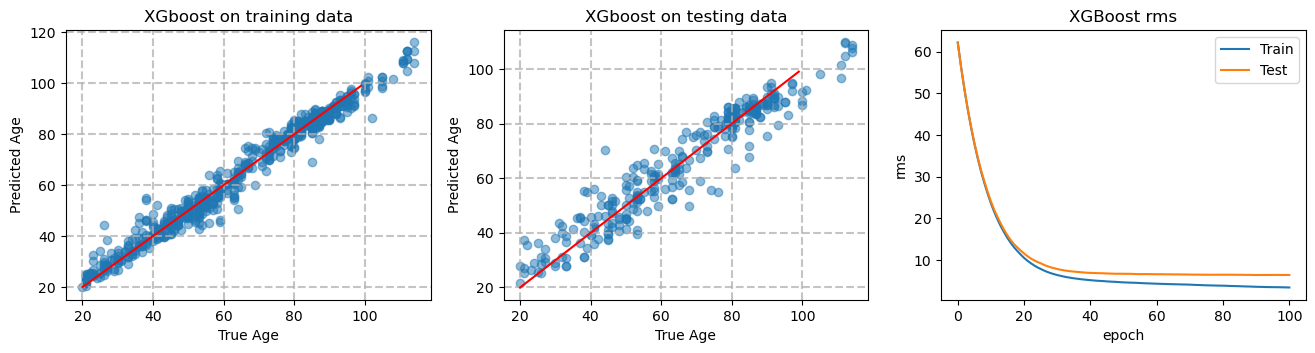

The number of training epochs was 101
The rms on the training data is 3.551 years
The rms on the testing data is 6.397 years
The r^2 on the training data is 0.975
The r^2 on the testing data is 0.916
The MAe on the training data is 2.508 years
The MAE on the testing data is 4.832


In [57]:
XG_100, rms_train, rms_test, r2_train, r2_test, feature_importances_ = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=10, plot=True)

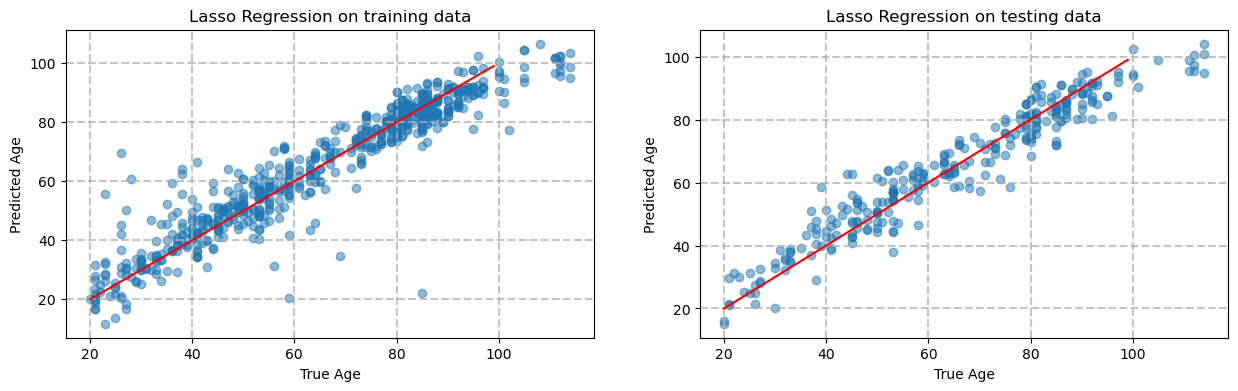

The rms on the training data is 7.304 years
The rms on the testing data is 6.215 years
The r^2 on the training data is 0.896
The r^2 on the testing data is 0.921
The MAe on the training data is 4.837 years
The MAE on the testing data is 4.769 years


In [58]:
mod_lasso_100, rms_train, rms_test, r2_train, r2_test = lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

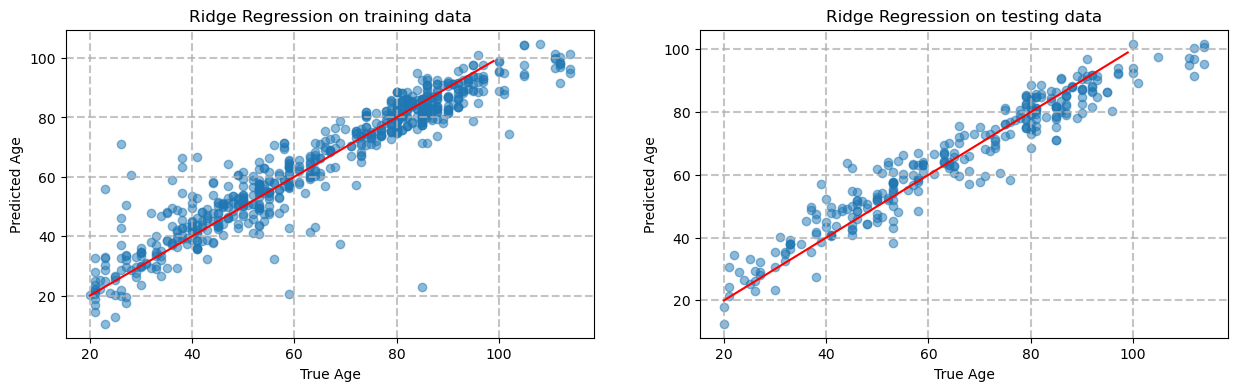

The rms on the training data is 7.466 years
The rms on the testing data is 6.366 years
The r^2 on the training data is 0.892
The r^2 on the testing data is 0.917
The MAe on the training data is 4.967 years
The MAE on the testing data is 4.886 years


In [59]:
mod_ridge_100, rms_train, rms_test, r2_train, r2_test = ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5)

In [ ]:
# # Save models
# import pickle

# with open('mod_100_brain', 'wb') as fp:
#     pickle.dump(mod_100, fp)
    
# with open('XG_100_brain', 'wb') as fp:
#     pickle.dump(XG_100, fp)
    
# with open('mod_lasso_100_brain', 'wb') as fp:
#     pickle.dump(mod_lasso_100, fp)
    
# with open('mod_ridge_100_brain', 'wb') as fp:
#     pickle.dump(mod_ridge_100, fp)

### Looking at model on saved data

In [60]:
plt.rcdefaults()
X_saved = df_p_saved[Top100_cpgs_XGboost_brain]
y_saved = df_p_saved.age

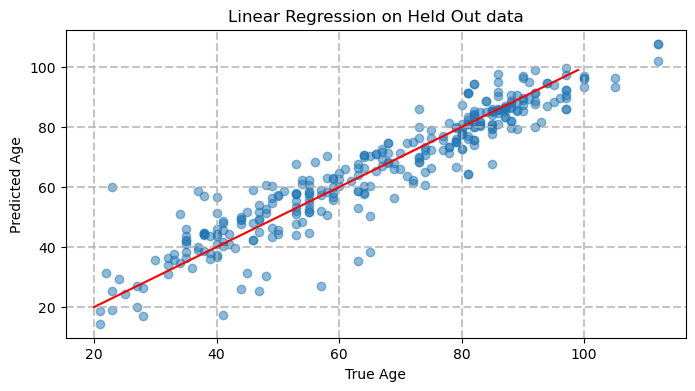

The MSE on the saved data is 53.798 years
The rms on the saved data is 7.335 years
The r^2 on the saved data is 0.877
The mae on the saved data is 5.292 years
The correlation on the held out data true-predicted is 0.937


In [61]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100, mtype='Linear Regression', figsize=(8,4), xlim=None)

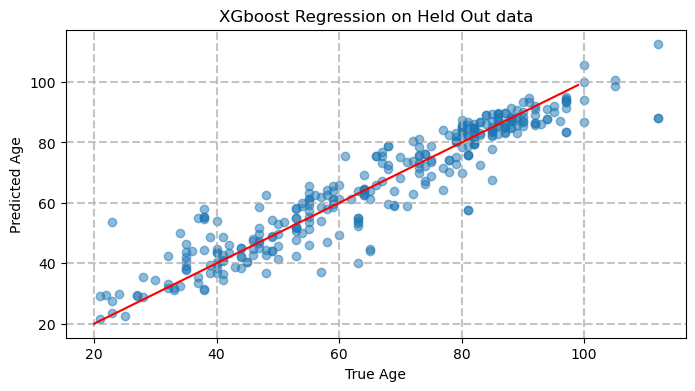

The MSE on the saved data is 47.784 years
The rms on the saved data is 6.913 years
The r^2 on the saved data is 0.891
The mae on the saved data is 4.914 years
The correlation on the held out data true-predicted is 0.944


In [62]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, XG_100, mtype='XGboost Regression', figsize=(8,4), xlim=None)

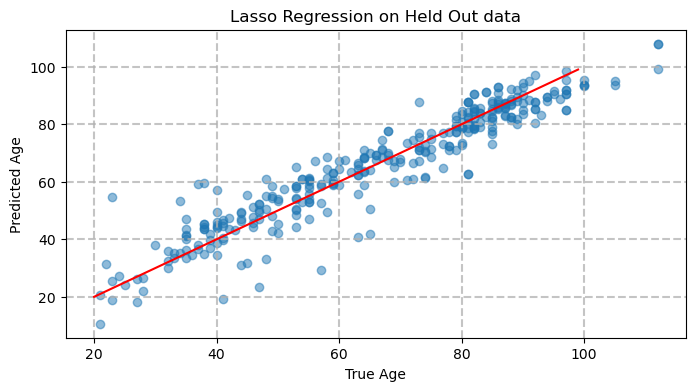

The MSE on the saved data is 47.765 years
The rms on the saved data is 6.911 years
The r^2 on the saved data is 0.891
The mae on the saved data is 5.011 years
The correlation on the held out data true-predicted is 0.944


In [63]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_lasso_100, mtype='Lasso Regression', figsize=(8,4), xlim=None)

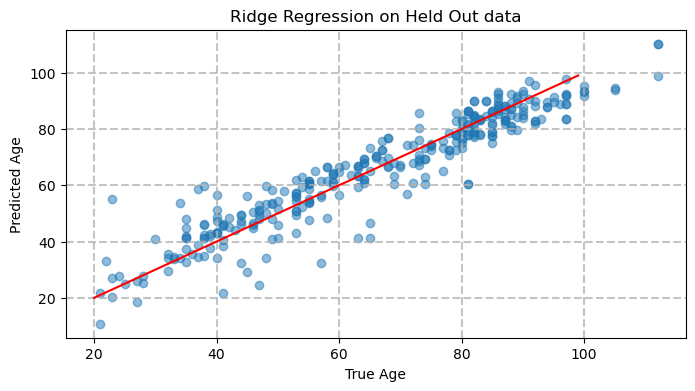

The MSE on the saved data is 49.242 years
The rms on the saved data is 7.017 years
The r^2 on the saved data is 0.888
The mae on the saved data is 5.189 years
The correlation on the held out data true-predicted is 0.942


In [64]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_ridge_100, mtype='Ridge Regression', figsize=(8,4), xlim=None)

In [66]:
with open('./models/mod_100_whole_blood', 'rb') as fp:
    mod_100_whole_blood = pickle.load(fp)

with open('./models/XG_100_whole_blood', 'rb') as fp:
    XG_100_whole_blood = pickle.load(fp)
    
with open('./models/mod_lasso_100_whole_blood', 'rb') as fp:
    mod_lasso_100_whole_blood = pickle.load(fp)
    
with open('./models/mod_ridge_100_whole_blood', 'rb') as fp:
    mod_ridge_100_whole_blood = pickle.load(fp)


In [67]:
with open('./models/mod_100_brain', 'rb') as fp:
    mod_100_brain = pickle.load(fp)

with open('./models/XG_100_brain', 'rb') as fp:
    XG_100_brain = pickle.load(fp)
    
with open('./models/mod_lasso_100_brain', 'rb') as fp:
    mod_lasso_100_brain = pickle.load(fp)
    
with open('./models/mod_ridge_100_brain', 'rb') as fp:
    mod_ridge_100_brain = pickle.load(fp)

In [69]:
import pickle

with open('./cpgs_ranked/cpgs_XGboost_breast_ranked', 'rb') as fp:
    cpgs_XGboost_breast_ranked = pickle.load(fp)
    
with open('./cpgs_ranked/cpgs_XGboost_brain_ranked', 'rb') as fp:
    cpgs_XGboost_brain_ranked = pickle.load(fp)
    
with open('./cpgs_ranked/cpgs_XGboost_whole_blood_ranked', 'rb') as fp:
    cpgs_XGboost_whole_blood_ranked = pickle.load(fp)
       

In [71]:
X_saved = df_p_saved[cpgs_XGboost_whole_blood_ranked[:100]]
y_saved = df_p_saved.age

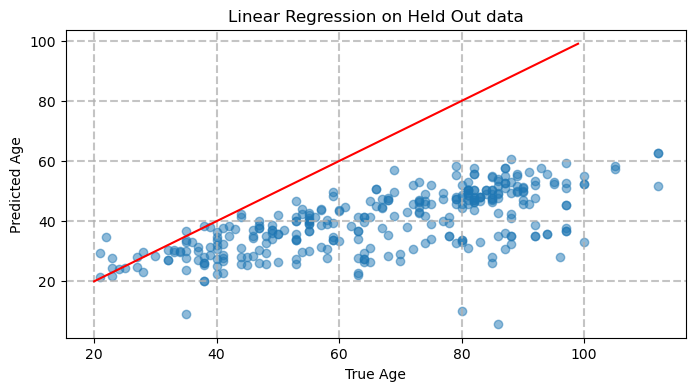

The MSE on the saved data is 954.362 years
The rms on the saved data is 30.893 years
The r^2 on the saved data is -1.178
The mae on the saved data is 26.647 years
The correlation on the held out data true-predicted is 0.672


In [72]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100_whole_blood, mtype='Linear Regression', figsize=(8,4), xlim=None)


In [1]:
X_saved = df_p_saved[cpgs_XGboost_breast_ranked[:100]]
y_saved = df_p_saved.age

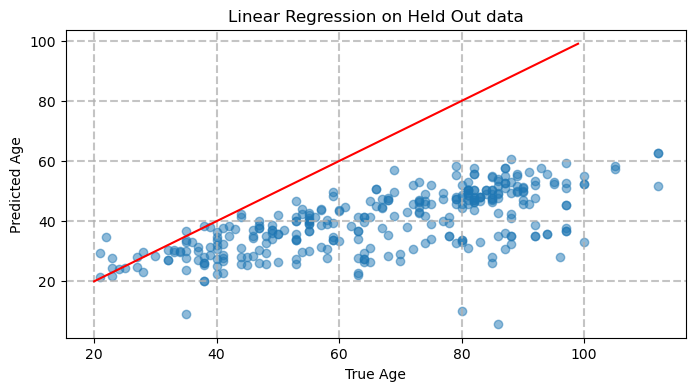

The MSE on the saved data is 954.362 years
The rms on the saved data is 30.893 years
The r^2 on the saved data is -1.178
The mae on the saved data is 26.647 years
The correlation on the held out data true-predicted is 0.672


In [72]:
preds, MSE, rms, r2, MAE, r_corr = test_model_on_heldout_data(X_saved, y_saved, mod_100_breast, mtype='Linear Regression', figsize=(8,4), xlim=None)


## LOADS

In [ ]:
# import pickle

# with open('mod_lg_best_dropNA_XGboost50', 'rb') as fp:
#     mod_lg_best_dropNA_XGboost50 = pickle.load(fp)
    
# with open('Top100cpgs_dropNA_XGboost50', 'rb') as fp:
#     Top100cpgs_dropNA_XGboost50 = pickle.load(fp)
       
# with open('Top42_common_dropNA_corr1000_XGboost50', 'rb') as fp:
#     Top42_common_dropNA_corr1000_XGboost50 = pickle.load(fp) 

# with open('mod_lg_best_dropNA_42common', 'rb') as fp:
#     mod_lg_best_dropNA_42common = pickle.load(fp)

## FUNCTIONS

In [ ]:
def test_model_on_heldout_data(X_saved, y_saved, model, mtype='Linear Regression', figsize=(8,4), xlim=None):
    
    # Using  model to make predictions on saved data
    preds_on_saved = model.predict(X_saved)
    MSE_test = mean_squared_error(y_saved, preds_on_saved)
    rms_test = (mean_squared_error(y_saved, preds_on_saved))**0.5
    r2_test = r2_score(y_saved, preds_on_saved)
    MAE_test = mean_absolute_error(y_saved, preds_on_saved)
    r_test_corr = np.corrcoef(y_saved, preds_on_saved)[0,1] # preds_on_saved
    
    # Plotting results
    model_type = mtype

    fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.scatter(y_saved, preds_on_saved, alpha=0.5)
    ax.plot(range(20,100), range(20,100), c='red')
    ax.set_xlabel('True Age')
    if xlim !=None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel('Predicted Age')
    ax.grid(True, lw=1.5, ls='--', alpha=0.75)
    ax.set_title(f'{model_type} on Held Out data')
    plt.show()

    # print metric
    print(f'The MSE on the saved data is {MSE_test:.3f} years')
    print(f'The rms on the saved data is {rms_test:.3f} years')
    print(f'The r^2 on the saved data is {r2_test:.3f}')
    print(f'The mae on the saved data is {MAE_test:.3f} years')
    print(f'The correlation on the held out data true-predicted is {r_test_corr:.3f}')
    
    return preds_on_saved, MSE_test, rms_test, r2_test, MAE_test, r_test_corr

In [ ]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [ ]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
    
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(16,3.5))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f}')
    
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

In [ ]:
# Function for running a ridge Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import RidgeCV
def ridgeCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = RidgeCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Ridge Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [ ]:
# Function for running a lasso Regression model with CV on alpha
# and plot and print results
from sklearn.linear_model import LassoCV
def lassoCV_regress(X_train, y_train, X_test, y_test, plot=True, alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_test = mean_absolute_error(y_test, preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Lasso Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    print(f'The MAe on the training data is {mae_train:.3f} years')
    print(f'The MAE on the testing data is {mae_test:.3f} years')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [ ]:
# repeat_XGBoost numtrials times using a different split each time 
# returns importance scores for each run in a df 
def repeat_XGBoost(df_processed, numtrials, early_stopping_rounds = 10, test_size=0.20):
    X = df_processed.iloc[:,5:]
    y = df_processed.age
    importances = []
    rms_train = []
    rms_test = []
    r2_train = []
    r2_test = []
    for i in range(numtrials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        
        XG = XGBRegressor(objective='reg:squarederror',
                    n_estimators=200,
                    min_child_weight=1,
                    max_depth=3,
                    subsample=0.7,
                    colsample_bytree=0.5,
                    learning_rate=0.1)
    
        eval_set = [(X_train, y_train),(X_test, y_test)]
        XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds, eval_set=eval_set, verbose=False)
        
        preds_train = XG.predict(X_train)
        preds_test = XG.predict(X_test)
        rms_train.append((mean_squared_error(y_train, preds_train))**0.5)
        rms_test.append((mean_squared_error(y_test, preds_test))**0.5)
        r2_train.append(r2_score(y_train, preds_train))
        r2_test.append(r2_score(y_test, preds_test))
        print(i+1, f'r^2 test = {r2_score(y_test, preds_test)}')
        importances.append(XG.feature_importances_)
    df_imp = pd.DataFrame(importances, columns = df_processed.columns[5:])
    df_imp = df_imp.transpose()
    cols = []
    for i in range(1,numtrials+1):
        cols.append('trial_'+str(i))
    df_imp.columns = cols
    df_imp['Mean'] = df_imp.mean(axis=1)
    df_imp['Std'] = df_imp.std(axis=1)
    return df_imp, rms_train, rms_test, r2_train, r2_test

# Takes df of importance scores produced by repeat_XGBoost and sorts by mean imp score
def importances_sorted_by_mean(df_imp):
    df_imp_sorted = df_imp.sort_values('Mean', ascending=False)
    return df_imp_sorted

# Makes a histogram of the frequecy of cgs in the top (top_num) importance scores
def histogram_of_top_CpGs_by_importance(df_imp, top_num=20):
    vs = []
    inds = []
    for col in df_imp.columns[:-2]:
        c = df_imp[col].sort_values(ascending=False)
        vs.append(c[:top_num])
        inds  = inds + list(c.index[:top_num])
    h = pd.Series(inds).value_counts()
    # Plotting the first 100 importance scores
    plt.figure(figsize = (30, 12))
    plt.bar(h.index[:100],h[:100])
    plt.title('Frequency of CpGs in the top 100 importances')
    plt.ylabel('Frequency')
    plt.xlabel('CpG')
    plt.xticks(fontsize = 16, rotation=90)
    plt.show()
    return inds, vs, h